In [1]:
Sys.setenv(RGL_USE_NULL = TRUE)
library(rgl)
library(lidR)
library(terra)
library(sf)

terra 1.7.18

Linking to GEOS 3.11.2, GDAL 3.6.3, PROJ 9.2.0; sf_use_s2() is TRUE


Attaching package: ‘sf’


The following object is masked from ‘package:lidR’:

    st_concave_hull




In [2]:
citation('lidR')


To cite package lidR in publications use both:

  Roussel, J.R., Auty, D., Coops, N. C., Tompalski, P., Goodbody, T. R.
  H., Sánchez Meador, A., Bourdon, J.F., De Boissieu, F., Achim, A.
  (2020). lidR : An R package for analysis of Airborne Laser Scanning
  (ALS) data. Remote Sensing of Environment, 251 (August), 112061.
  <doi:10.1016/j.rse.2020.112061>.

  Jean-Romain Roussel and David Auty (2023). Airborne LiDAR Data
  Manipulation and Visualization for Forestry Applications. R package
  version 4.0.3. https://cran.r-project.org/package=lidR

To see these entries in BibTeX format, use 'print(<citation>,
bibtex=TRUE)', 'toBibtex(.)', or set
'options(citation.bibtex.max=999)'.


## nDSM creation

In [ ]:
# read lasfile
#LASFILE <- "<input las file>"
las <- readLAS(LASFILE)

# classify ground
mycsf <- csf(sloop_smooth = TRUE, class_threshold = 1, cloth_resolution = 1, time_step = 1)
las <- classify(las,mycsf)

# filter ground points
gnd <- filter_ground((las))

# NOTE: raterize_terrain needed las to have ground classification 
dtm_tin <- rasterize_terrain(las, res =1, algorithm = tin())

# create nDSM
nlas <-las - dtm_tin


In [3]:
#nlas <- readLAS("Serigasawa/ndsm.las")

Warning message:
“Invalid data: 46277347 points with a return number equal to 0 found.”
Warning message:
“Invalid data: 46277347 points with a number of returns equal to 0 found.”


In [4]:
print(nlas)

class        : LAS (v1.2 format 2)
memory       : 2.1 Gb 
extent       : 68339.32, 68688.07, 181306.9, 181688.7 (xmin, xmax, ymin, ymax)
coord. ref.  : NA 
area         : 68832 units²
points       : 46.28 million points
density      : 672.32 points/units²


In [9]:
xmin <- 68340
xmax <- 68688
ymin <- 181307
ymax <- 181688

xmid <- xmin + ((xmax-xmin)/2)
ymid <- ymin + ((ymax-ymin)/2)
print(xmid)
print(ymid)

[1] 68514
[1] 181497.5


## tree top identification

In [5]:


# set crs if missing
st_crs(nlas) <- 6677

terra 1.7.18



In [71]:
chm <- rasterize_canopy(nlas, res = 0.5, algorithm = p2r(subcircle =0.1),pkg='terra')
# w <- matrix(1,3,3)
# smoothed <- terra::focal(chm, w, fun = mean, na.rm = TRUE)

In [20]:
col <- height.colors(25)

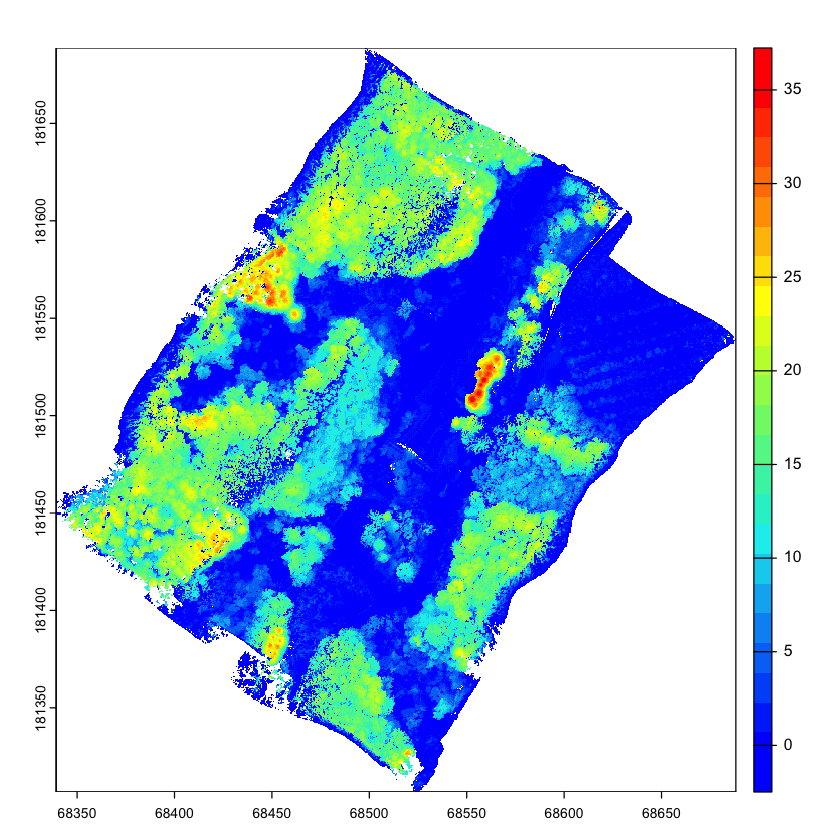

In [26]:
plot(chm,col = col)

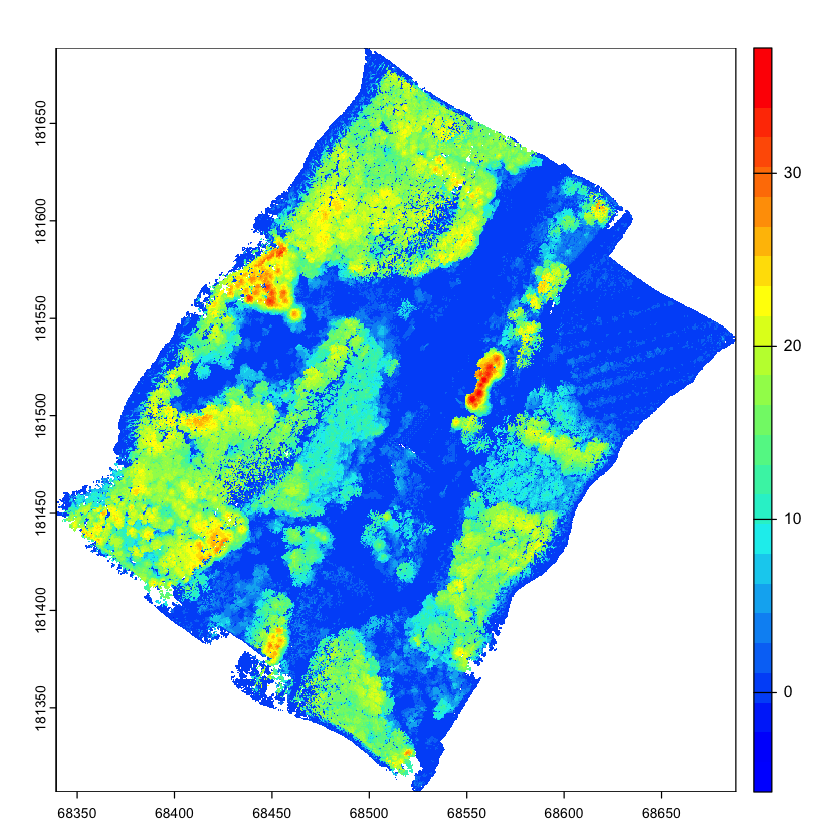

In [45]:
fill.na <- function(x, i=5) {if (is.na(x)[i]) {return(mean(x, na.rm=TRUE))} else {return(x[i])}}
w <- matrix(1,3,3)

filled <- terra::focal(chm, w, fun = fill.na)
plot(filled, col=col)

In [72]:
kernel <- matrix(1,3,3)
smoothed <- terra::focal(chm, w = kernel, fun = median, na.rm = TRUE)

#### pitfree algo for chm

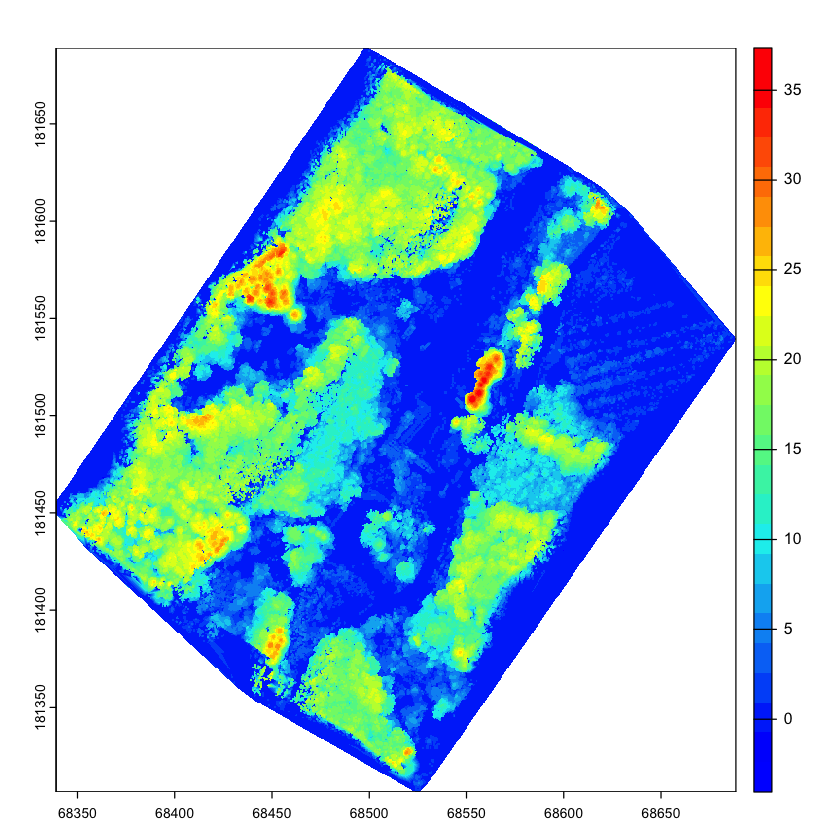

In [99]:
chm_tin = rasterize_canopy(nlas, res = 0.5 , p2r(0.2, na.fill = tin()))
plot(chm_tin, col=col)

### Segmentation of trees

#### Dalponte

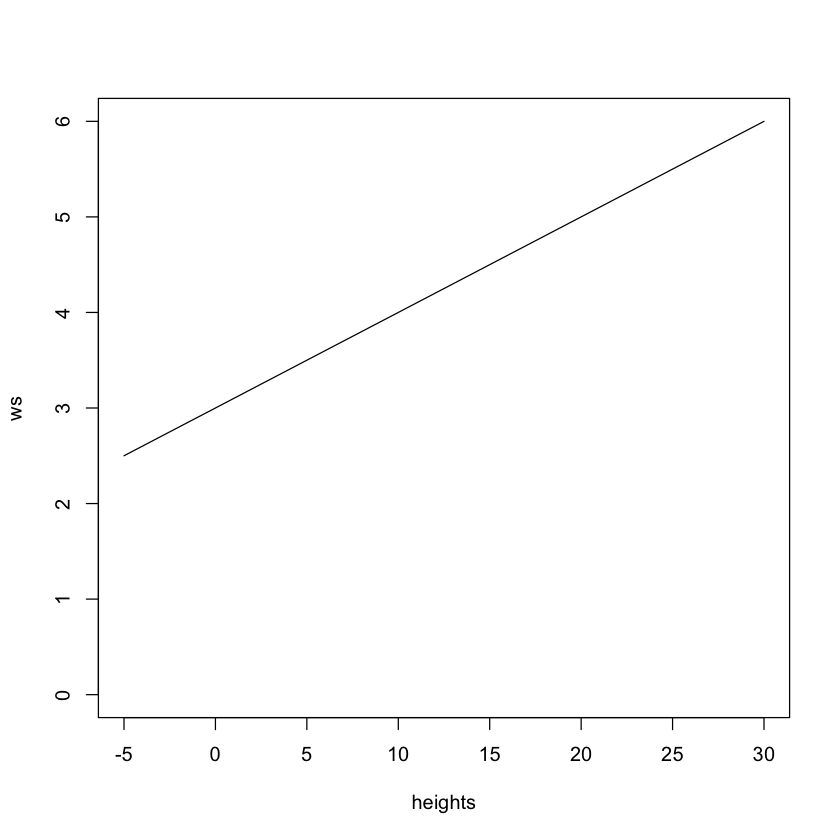

In [11]:
# window size for tree top detection
linear_ws <- function(x) {x*0.1 + 3}

heights <- seq(-5,30,0.5)
ws <- linear_ws(heights)
plot(heights, ws, type = 'l', ylim = c(0,6))

In [102]:
ttops <- locate_trees(chm_tin, lmf(linear_ws))

In [118]:
algo <- dalponte2016(chm_tin, ttops)
seg_las <- segment_trees(nlas, algo)

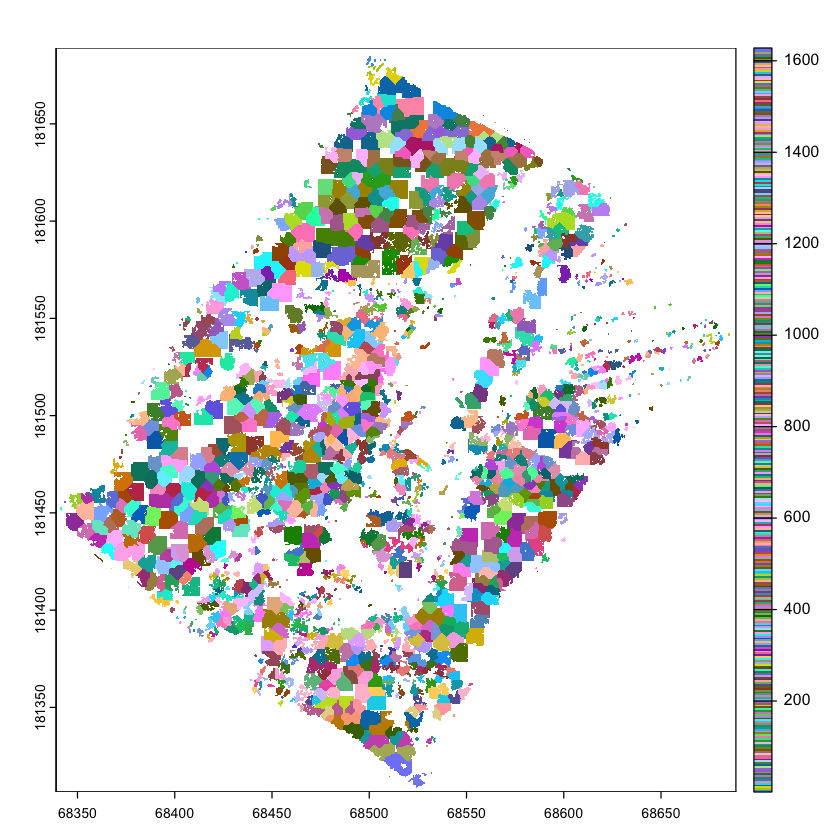

In [119]:
crowns <- algo()
plot(crowns, col = pastel.colors(400))

#### Watershed algo

In [96]:
#algo = watershed(chm_tin,th=6)
#seg_las = segment_trees(nlas,algo)

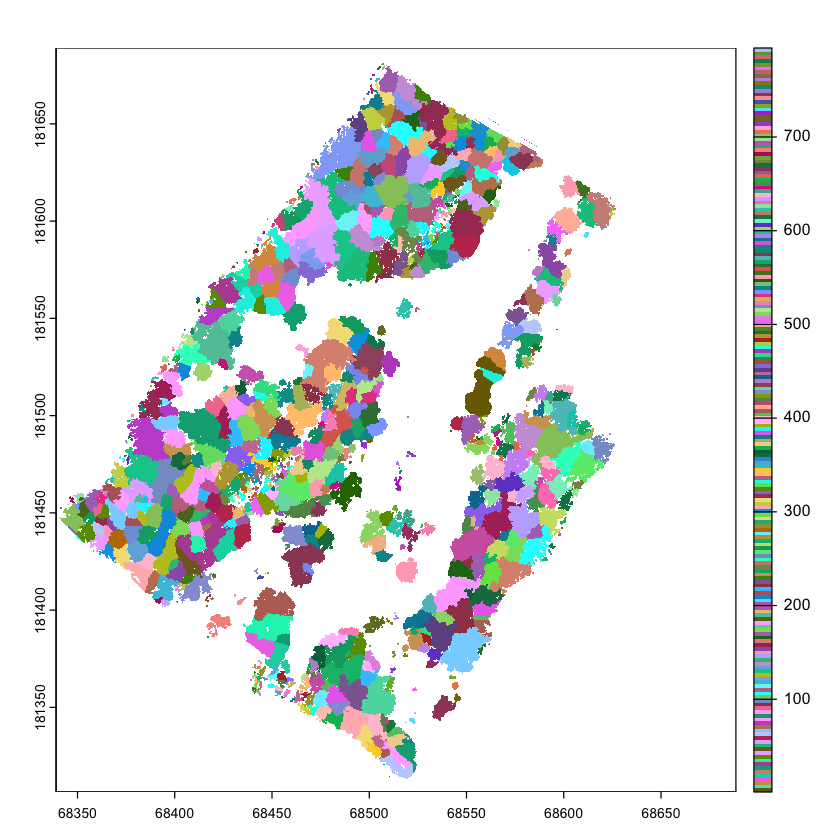

In [97]:
crowns <- algo()
plot(crowns, col = pastel.colors(200))

In [125]:
trees <- filter_poi(seg_las, !is.na(treeID))

In [121]:
writeLAS(trees, 'Serigasawa/nlas_segmented.las')

## Tree height

In [112]:
print(ttops)

Simple feature collection with 1628 features and 2 fields
Attribute-geometry relationship: 2 constant, 0 aggregate, 0 identity
Geometry type: POINT
Dimension:     XYZ
Bounding box:  xmin: 68341.25 ymin: 181311.2 xmax: 68685.25 ymax: 181684.2
Projected CRS: Tokyo / Japan Plane Rectangular CS IX
First 10 features:
   treeID    Z                       geometry
1       1 3.53 POINT Z (68500.25 181684.2 ...
2       2 5.23 POINT Z (68503.25 181683.2 ...
3       3 3.87 POINT Z (68505.75 181683.2 ...
4       4 2.77 POINT Z (68508.25 181683.2 ...
5       5 5.81 POINT Z (68501.75 181681.2 ...
6       6 5.59 POINT Z (68503.25 181679.8 ...
7       7 9.59 POINT Z (68505.25 181679.8 ...
8       8 5.38 POINT Z (68512.75 181678.8 ...
9       9 4.56 POINT Z (68500.25 181676.8 ...
10     10 7.50 POINT Z (68502.25 181675.2 ...


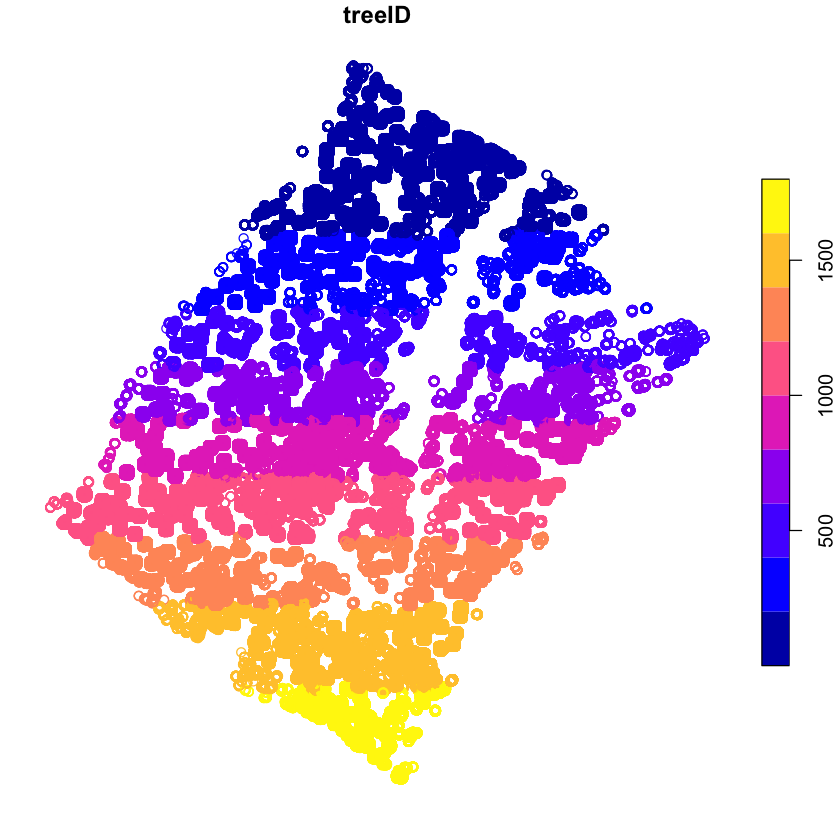

In [110]:
lsp = st_as_sf(as.spatial(trees))
plot(lsp[,"treeID"])

In [113]:
lspdf = cbind(st_drop_geometry(lsp),st_coordinates(lsp))
head(lspdf)

,Z,Intensity,ReturnNumber,NumberOfReturns,ScanDirectionFlag,EdgeOfFlightline,Classification,Synthetic_flag,Keypoint_flag,Withheld_flag,ScanAngleRank,UserData,PointSourceID,R,G,B,treeID,X,Y
,<dbl>,<int>,<int>,<int>,<int>,<int>,<int>,<lgl>,<lgl>,<lgl>,<int>,<int>,<int>,<int>,<int>,<int>,<dbl>,<dbl>,<dbl>
1,-0.35,73,0,0,0,0,1,FALSE,FALSE,FALSE,0,0,29,65535,65535,65535,895,68612.03,181483.9
2,4.95,9,0,0,0,0,1,FALSE,FALSE,FALSE,0,0,29,11051,11565,12850,838,68608.24,181493.8
3,0.33,57,0,0,0,0,1,FALSE,FALSE,FALSE,0,0,29,65535,65535,65535,787,68624.22,181500.2
4,17.96,5,0,0,0,0,1,FALSE,FALSE,FALSE,0,0,29,65535,65535,65535,925,68616.34,181478.8
5,12.45,5,0,0,0,0,1,FALSE,FALSE,FALSE,0,0,29,65535,65535,65535,895,68612.67,181484.7
6,17.60,7,0,0,0,0,1,FALSE,FALSE,FALSE,0,0,29,65535,65535,65535,905,68616.99,181483.3


In [126]:

## get max height of each tree
metrics <- tree_metrics(trees, ~list(z_max = max(Z)))
metrics.sf = st_as_sf(metrics)
head(metrics.sf)

,treeID,z_max,geometry
,<dbl>,<dbl>,<POINT [m]>
1,1,3.53,POINT Z (68500.23 181684 3.53)
2,2,5.23,POINT Z (68503.15 181682.8 ...
3,3,3.87,POINT Z (68505.77 181683.1 ...
4,4,2.77,POINT Z (68508.26 181683.1 ...
5,5,5.81,POINT Z (68501.74 181681.2 ...
6,6,5.59,POINT Z (68503.06 181679.6 ...


In [115]:
print(metrics.sf)

Simple feature collection with 1663 features and 2 fields
Geometry type: POINT
Dimension:     XYZ
Bounding box:  xmin: 68341.58 ymin: 181311 xmax: 68684.87 ymax: 181684
z_range:       zmin: -0.21 zmax: 37.35
Projected CRS: Tokyo / Japan Plane Rectangular CS IX
First 10 features:
   treeID z_max                       geometry
1       1  3.53 POINT Z (68500.23 181684 3.53)
2       2  3.87 POINT Z (68505.77 181683.1 ...
3       3  2.77 POINT Z (68508.26 181683.1 ...
4       4  5.23 POINT Z (68503.15 181682.8 ...
5       5  5.81 POINT Z (68501.74 181681.2 ...
6       6  5.59 POINT Z (68503.06 181679.6 ...
7       7  9.59 POINT Z (68505.61 181679.4 ...
8       8  5.38 POINT Z (68512.94 181678.4 ...
9       9  4.56 POINT Z (68500.64 181676.6 ...
10     10  0.25 POINT Z (68502.52 181675.2 ...


In [127]:
print(metrics)

                     coordinates treeID z_max
1       (68500.23, 181684, 3.53)      1  3.53
2     (68503.15, 181682.8, 5.23)      2  5.23
3     (68505.77, 181683.2, 3.87)      3  3.87
4     (68508.26, 181683.1, 2.77)      4  2.77
5     (68501.74, 181681.2, 5.81)      5  5.81
6     (68503.06, 181679.6, 5.59)      6  5.59
7     (68505.61, 181679.4, 9.59)      7  9.59
8     (68512.94, 181678.4, 5.38)      8  5.38
9     (68500.64, 181676.6, 4.56)      9  4.56
10      (68502.5, 181675.1, 7.5)     10  7.50
11   (68513.21, 181674.6, 21.75)     11 21.75
12   (68504.31, 181670.6, 11.76)     12 11.76
13    (68501.22, 181673.1, 6.56)     13  6.56
14      (68519, 181670.6, 22.51)     14 22.51
15   (68509.39, 181672.6, 19.36)     15 19.36
16      (68499.01, 181668, 4.55)     16  4.55
17     (68522.08, 181668, 22.44)     17 22.44
18    (68499.34, 181665.5, 7.01)     18  7.01
19     (68497.7, 181663.2, 6.24)     19  6.24
20    (68496.34, 181661.1, 5.83)     20  5.83
21     (68509.07, 181661, 19.16)  

In [124]:
write.csv(metrics.sf, "Serigasawa/trees_height.csv")